# Analysis of parent comments clusters with an anomalous sarcastic response
## Introduction 
The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0). The project goal is, given only the parent comment in a specific subreddit, identify parent comment clusters that receive an amount of sarcastic comments that deviate from the subreddit average. The project then focuses on document clustering, topic detection, and keyword ex- traction.

### References

• Dimo Angelov, Top2Vec: Distributed Representations of Topics, [link](https://arxiv.org/abs/2008.09470)

• Grootendorst Maarten, BERTopic, [link](https://github.com/MaartenGr/BERTopic)

• Grootendorst Maarten, Keyword Extraction with BERT, [link](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea)

• L. McInnes, J. Healy, S. Astels, hdbscan: Hierarchical density based clus- tering In: Journal of Open Source Software, The Open Journal, volume 2, number 11. 2017, [link](https://www.theoj.org/joss-papers/joss.00205/10.21105.joss.00205.pdf)

• McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Pro- jection for Dimension Reduction, [link](https://arxiv.org/abs/1802.03426)

• Universal Sentence Encoder, [link](https://arxiv.org/abs/1803.11175)

### Download dataset 

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/danofer/sarcasm/download")

### Import USE 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import re
import seaborn as sns
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [2]:
import numpy as np
import pandas as pd
reddit = pd.read_csv('sarcasm/train-balanced-sarcasm.csv')
reddit

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


### Data cleaning
Removing unnecessary columns and filtering by subreddit

In [3]:
reddit.drop(['comment','author','score','ups','downs','date','created_utc'],axis=1,inplace=True)
reddit.head()

,label,subreddit,parent_comment
0,0,politics,"Yeah, I get that argument. At this point, I'd ..."
1,0,nba,The blazers and Mavericks (The wests 5 and 6 s...
2,0,nfl,They're favored to win.
3,0,BlackPeopleTwitter,deadass don't kill my buzz
4,0,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...


In [4]:
subreddit = reddit[(reddit['subreddit'] == 'pcmasterrace')]
subreddit.reset_index(drop=True, inplace=True)
subreddit

,label,subreddit,parent_comment
0,0,pcmasterrace,What to upgrade? I have $500 to spend (mainly ...
1,0,pcmasterrace,Popular YouTuber DemolitionRanch joins the mas...
2,0,pcmasterrace,Youtube just is getting glorious 21:9 on their...
3,0,pcmasterrace,I made a CPU ornament and thought you guys mig...
4,1,pcmasterrace,Wccftech blows EVGA issues out of proportion -...
...,...,...,...
18983,1,pcmasterrace,Can we please stop using this as some sort of ...
18984,1,pcmasterrace,peasant uses games for windows live to judge p...
18985,0,pcmasterrace,Source? I'm not saying I disagree or agree wit...
18986,0,pcmasterrace,It's seen as a great budget card as long as yo...


### Average sarcasm 

In [5]:
subreddit.groupby(['subreddit']).mean()

,label
subreddit,
pcmasterrace,0.566674


### Tri-grams extraction 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

n_gram_range = (3, 3)
stop_words = "english"

count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(subreddit.parent_comment)
candidates = count.get_feature_names()

### Universal Sentence Encoder
Vectorization of various parent_comments

In [7]:
embeddings = embed(subreddit['parent_comment'])

### Dimensionality Reduction

In [8]:
import umap
umap_embeddings = umap.UMAP(n_neighbors = 15, 
                            n_components = 5, 
                            metric='cosine').fit_transform(embeddings)

### Clustering

In [9]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size = 50,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

### Plotting

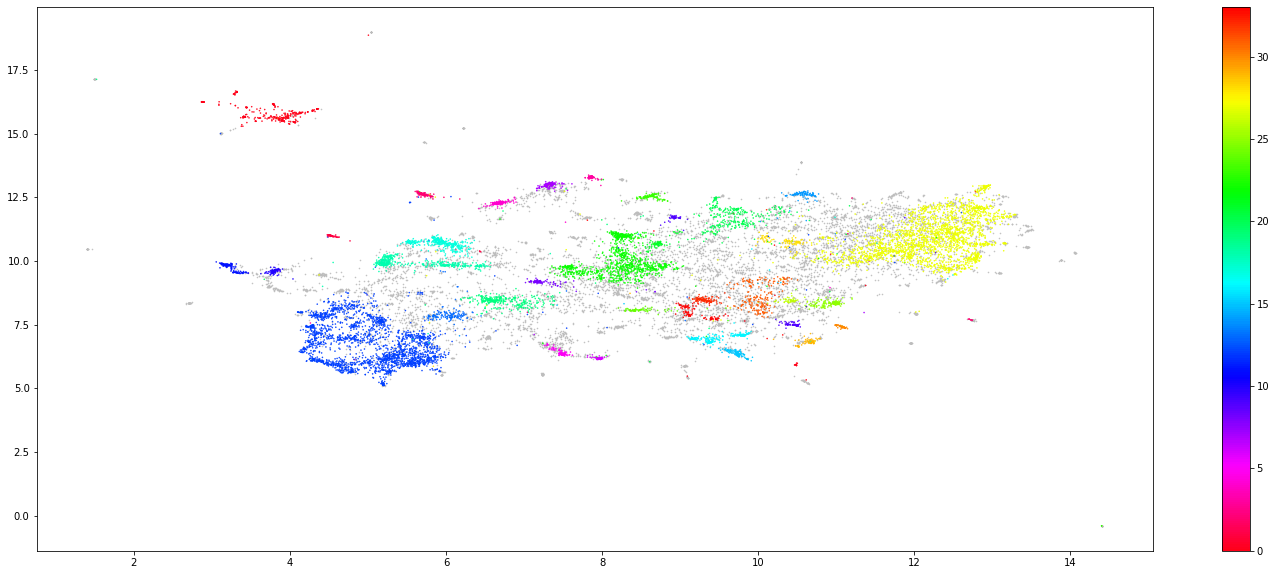

In [10]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(25, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.3)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.3, cmap='hsv_r')
plt.colorbar()

### Topic Size

In [11]:
docs_df = pd.DataFrame(subreddit, columns=["parent_comment"])
docs_df['Topic'] = cluster.labels_

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .parent_comment
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "parent_comment": "Size"}, axis='columns')
                     .sort_values("Topic", ascending=True))
    return topic_sizes

results = extract_topic_sizes(docs_df)

### Mean pooling cluster vectors

In [12]:
docs_embed = pd.DataFrame(np.concatenate([embeddings]))
docs_embed['Topic'] = cluster.labels_
docs_embed['Label'] = subreddit['label']
mean_embed = docs_embed.groupby(['Topic'], as_index = False).mean()
mean_embed

,Topic,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,Label
0,-1,-0.000115,-0.016818,-0.000843,0.001956,0.011887,-0.005612,0.012784,0.001052,0.008644,...,0.017312,0.005675,-0.005941,0.019574,-0.006069,-0.003342,-0.001814,0.005805,-0.005678,0.563070
1,0,-0.056278,-0.066283,0.005734,0.001990,0.036453,-0.000667,0.015066,0.020395,0.000129,...,0.012747,0.014909,-0.004874,0.037935,-0.034486,-0.030571,-0.020957,-0.016088,0.011008,0.209945
2,1,0.009872,-0.012172,-0.041755,0.013666,0.000940,-0.006862,0.026965,-0.027633,0.022109,...,0.022576,-0.000096,-0.058540,0.002814,-0.028620,-0.020346,0.026382,0.018185,-0.001353,0.661538
3,2,0.020573,-0.034320,-0.007035,-0.028197,0.000467,-0.022258,-0.012153,-0.021025,0.017153,...,0.025676,-0.023893,-0.007735,0.020101,-0.004699,0.001901,-0.008694,-0.001124,-0.023361,0.683616
4,3,-0.013604,-0.002097,-0.008994,-0.014153,0.013384,0.023924,0.035666,-0.010421,0.016925,...,0.032210,-0.008396,-0.074906,-0.036445,0.004310,-0.005707,-0.006214,-0.001075,-0.007625,0.542373
5,4,0.010473,-0.030860,0.004636,-0.003077,0.008105,0.007677,0.011197,-0.000859,0.004353,...,0.029298,-0.001430,-0.023786,-0.078112,-0.014596,-0.027069,0.021435,-0.013893,-0.013846,0.503067
6,5,0.031400,-0.017966,-0.005342,0.007117,0.030791,-0.032471,0.004610,-0.022009,-0.011095,...,0.020912,-0.014701,-0.005981,0.044763,0.015653,-0.019599,-0.004993,-0.024736,0.015302,0.687500
7,6,-0.020342,-0.031663,-0.005192,-0.012173,0.045848,-0.070406,-0.005461,-0.018177,0.014705,...,0.028372,-0.010639,0.020710,0.028584,-0.045461,-0.031967,0.036058,-0.013204,-0.018802,0.630137
8,7,0.001586,-0.031573,-0.030305,-0.020657,-0.005805,-0.004531,0.034763,-0.008814,0.015261,...,0.037460,0.009875,-0.004698,0.012240,-0.003461,-0.014444,0.030268,-0.025532,0.010381,0.484076
9,8,0.005250,-0.011220,-0.011778,0.022648,0.023529,0.011717,0.019129,-0.018055,0.018674,...,0.027958,0.016833,0.005059,0.040962,0.017571,0.012455,0.013704,-0.007009,-0.000240,0.570000


### Embeddings tri-grams

In [13]:
candidate_embeddings = embed(candidates)

### Keywords Extraction

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
Keywords = []
for i in range(len(mean_embed)):
    top_n = 5
    distances = cosine_similarity(mean_embed.iloc[i:i+1, 1:513], candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    Keywords.append(keywords)

### Results

In [15]:
pd.set_option('display.max_colwidth', None)
results['Keywords'] = Keywords
results['Label'] = mean_embed['Label']
sorted_results = results.sort_values(by='Label', ascending=False)
sorted_results

,Topic,Size,Keywords,Label
18,17,368,"[fps confirmed 30fps, hey 60 fps, fps play 60fps, atleast getting 60fps, wait 60 fps]",0.779891
31,30,57,"[preordering stop complaining, wont preorder just, whats point preordering, fuck pre order, fuck preorder game]",0.701754
6,5,112,"[macs unlike pc, macs shitty thats, macs just expensive, doesn like macs, macs better pcs]",0.687500
3,2,177,"[g46 ram 12gb, just got ram, 6700k 16gb ram, 5820k 16gb ram, 12gb ram fucking]",0.683616
23,22,995,"[filthy console peasant, peasants think pc, peasant thinks pc, pc masterrace peasant, peasant thinks consoles]",0.678392
15,14,102,"[yeah going upgrade, got little upgrade, just little upgrade, got nice upgrade, finally got upgrade]",0.666667
2,1,65,"[vive putting psvr, oculus rift cv1, vive vs oculus, oculus 600 vr, oculus vr thing]",0.661538
7,6,73,"[ve fucking linux, linux use windows, linux distros people, just install linux, linux distros honestly]",0.630137
17,16,244,"[modding skyrim amazing, mod shit skyrim, ruined skyrim mods, modding skyrim feels, just fallout mods]",0.622951
30,29,100,"[does sorry ubisoft, ubisoft doesn want, admit ubisoft game, ubisoft likes game, really want ubisoft]",0.620000


In [16]:
sorted_results[(sorted_results['Label'] > 0.6) | (sorted_results['Label'] < 0.5)]

,Topic,Size,Keywords,Label
18,17,368,"[fps confirmed 30fps, hey 60 fps, fps play 60fps, atleast getting 60fps, wait 60 fps]",0.779891
31,30,57,"[preordering stop complaining, wont preorder just, whats point preordering, fuck pre order, fuck preorder game]",0.701754
6,5,112,"[macs unlike pc, macs shitty thats, macs just expensive, doesn like macs, macs better pcs]",0.687500
3,2,177,"[g46 ram 12gb, just got ram, 6700k 16gb ram, 5820k 16gb ram, 12gb ram fucking]",0.683616
23,22,995,"[filthy console peasant, peasants think pc, peasant thinks pc, pc masterrace peasant, peasant thinks consoles]",0.678392
15,14,102,"[yeah going upgrade, got little upgrade, just little upgrade, got nice upgrade, finally got upgrade]",0.666667
2,1,65,"[vive putting psvr, oculus rift cv1, vive vs oculus, oculus 600 vr, oculus vr thing]",0.661538
7,6,73,"[ve fucking linux, linux use windows, linux distros people, just install linux, linux distros honestly]",0.630137
17,16,244,"[modding skyrim amazing, mod shit skyrim, ruined skyrim mods, modding skyrim feels, just fallout mods]",0.622951
30,29,100,"[does sorry ubisoft, ubisoft doesn want, admit ubisoft game, ubisoft likes game, really want ubisoft]",0.620000
